In [22]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.table import Table, QTable, vstack
from astropy.coordinates import match_coordinates_sky, SkyCoord, Distance
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM, Planck15

get_ipython().run_line_magic('matplotlib', 'inline')

Reading fits files and matching:

In [23]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

spt1 = Table.read('2500d_cluster_sample_Bocquet19.fits', format = 'fits')
spt2 = Table.read('sptecs_catalog_oct919.fits', format = 'fits')
spt = vstack([spt1, spt2], join_type='inner')
rm = Table.read('y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt20_vl50_catalog.fit', format = 'fits')

spt_id, spt_z = spt['SPT_ID'], spt['REDSHIFT']
spt_ra_dec = SkyCoord(ra = spt['RA'] * u.degree, dec = spt['DEC'] * u.degree, distance = Distance(z = spt_z, cosmology = cosmo))

rm_id, rm_z, rm_chisq = rm['MEM_MATCH_ID'], rm['Z_LAMBDA'], np.array(rm['LAMBDA_CHISQ'])
rm_ra_dec = SkyCoord(ra = rm['RA'] * u.degree, dec = rm['DEC'] * u.degree, distance = Distance(z = rm_z, cosmology = cosmo))


spt = QTable([spt_id, spt_ra_dec, spt_z], names = ('id', 'ra, dec', 'z'))
rm = QTable([rm_id, rm_ra_dec, rm_z], names = ('id', 'ra, dec', 'z'))


idx, sep2d, dist3d = match_coordinates_sky(rm['ra, dec'], spt['ra, dec']) #the order counts, len(rm)>>len(spt)
zdist = abs(spt['z'][idx]-rm['z'])

bln = (sep2d.arcmin < 10) & (zdist < 0.1)
matches_raw = {'rm_spt_ids':   np.column_stack((np.where(bln)[0], idx[bln])), 
               'sep2d_arcmin': sep2d[bln].arcmin, 
               'z':            rm['z'][bln], 
               'arcmin_to_mpc':  Planck15.arcsec_per_kpc_comoving(zdist[bln]).to(u.arcmin/u.Mpc).value }
rm_m_ids, spt_m_ids = matches_raw['rm_spt_ids'].T
rm_m_chisq = rm_chisq[bln]

matches = {'rm_spt_ids':[], 'sep2d_arcmin':[], 'z': [], 'dist_Mpc':[]}
for i in range(len(spt_m_ids)):
    result = np.where(spt_m_ids == spt_m_ids[i])[0]
    if len(result)==1:
        matches['rm_spt_ids'].append(list(matches_raw['rm_spt_ids'][result[0]]))
        matches['sep2d_arcmin'].append(matches_raw['sep2d_arcmin'][result[0]]) 
        matches['z'].append(matches_raw['z'][result[0]])
        matches['dist_Mpc'].append(matches_raw['sep2d_arcmin'][result[0]]/matches_raw['arcmin_to_mpc'][result[0]])
    if len(result)>1:
        rm_new_m = rm_m_ids[result[np.where(np.array(rm_m_chisq[result]) == np.amax(np.array(rm_m_chisq[result])))]]
        new_id = np.where(matches_raw['rm_spt_ids'] == rm_new_m)[0][0]
        matches['rm_spt_ids'].append(list(matches_raw['rm_spt_ids'][new_id]))
        matches['sep2d_arcmin'].append(matches_raw['sep2d_arcmin'][new_id]) 
        matches['z'].append(matches_raw['z'][new_id])
        matches['dist_Mpc'].append(matches_raw['sep2d_arcmin'][new_id]/matches_raw['arcmin_to_mpc'][new_id])        

spt_ids = np.array(matches['rm_spt_ids']).T[1]
spt_z_m = np.array(spt['z'][spt_ids])
#rm_z_m = np.array(matches['z'])
#dist_spt_m = Distance(z = spt_z_m, cosmology = cosmo)
#dist_rm_m = Distance(z = rm_z_m, cosmology = cosmo)

offset = np.array(matches['dist_Mpc'])
offset_err = np.sqrt(np.sum(offset**2)/len(offset))

Plot:

(-10, 1119)

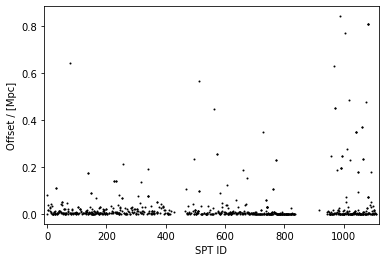

In [24]:
plt.errorbar(spt_ids, offset, fmt = 'k.', ms = 2)
plt.ylabel(r'Offset / [Mpc]')
plt.xlabel(r'SPT ID')
plt.xlim(-10, max(spt_ids) + 10)

Text(0.5, 0, 'SPT z')

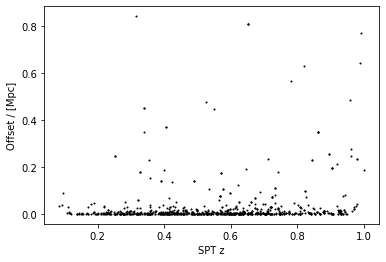

In [25]:
plt.errorbar(spt_z_m, offset, fmt = 'k.', ms = 2)
plt.ylabel(r'Offset / [Mpc]')
plt.xlabel(r'SPT z')

Text(0, 0.5, '$\\mathrm{N} / \\mathrm{N}_{tot}$')

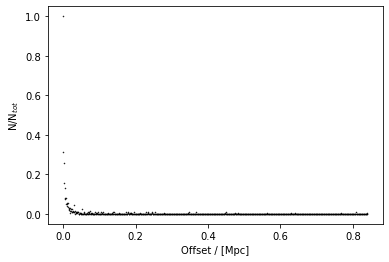

In [26]:
nbin = len(offset)
bins = np.zeros((nbin) + 1)

bin_width = (max(offset) - min(offset)) / nbin
for i in range(len(offset)):
    bins[int(offset[i] / bin_width)] += 1
bins = bins / max(bins)

plt.plot(bin_width * range(nbin + 1) + min(offset), bins, 'k.', ms = 1)
plt.xlabel(r'Offset / [Mpc]')
plt.ylabel(r'$\mathrm{N} / \mathrm{N}_{tot}$')

# Rayleigh Distribution:
$$P(x) = \frac{x}{\sigma^2}\mathrm{e}^{-0.5({x}/{\sigma})^2} \text{ and } \log(P(x)) = -2\log(\sigma) - \frac{x^2}{2\sigma ^2} + \log(x)$$



In [27]:
def log_prior(theta):
    if theta > 0:
        return 0.0
    return -np.inf

def log_likelihood(x, sigma):
    log_l = np.sum(- 2 * np.log(sigma) - 0.5 * (x / sigma)**2 + np.log(x))
    return log_l

def log_posterior(theta, x, sigma):
    log_prior = log_prior(theta)
    if not np.isfinite(log_prior):
        return - np.inf
    log_like = log_likelihood(theta, x, sigma)
    log_post = log_like + log_prior
    return log_post, log_prior, log_like


import emcee

sigma_arr = offset_err + 0.1 * np.random.random((16)) # ??
#sigma_arr = np.linspace(0, 2 * offset_err, 100)
nwalkers = len(sigma_arr)

sampler = emcee.EnsembleSampler(nwalkers, 1, log_posterior, args=(offset, offset_err))
sampler.run_mcmc(sigma_arr, 2000, progress = True);

ValueError: incompatible input dimensions